## Commodity Price Analysis

This part of the project will focus on analysing commodity prices following the start of the genocide in Gaza.

The commodity_price_trends and commodity_price_change_from_baseline marts are used for analysis, which are based on the following data: https://data.humdata.org/dataset/state-of-palestine-price-of-basic-commodities-in-gaza

The baseline price column is the commodity price before the start of the genocide, and all other listed prices are during the genocide. All percentage changes are measured relative to the baseline price.

### Hypothesis

Periods of intensified hostilities are expected to coincide with higher average commodity prices - driven by reduced availablity of humanitarian aid, restrictions on movement and disruptions to supply chains.

Conversely, this could mean that commodity prices are relatively lower during ceasefires, which occurred during the following dates:
- 24th November 2023 to 11th January 2024
- 19th January 2025 to 17th March 2025
- 3rd October 2025 to present

With regards to specific items, it is expected that prices will generally increase over time relative to the pre-October 2023 baseline, reflecting sustained supply constraints. The magnitude of price increases is expected to vary by commodity. Items essential for survival are expected to experience the strongest price inflation due to sustained demand. However, these key items will also likely be prioritised in aid distribution which may counteract the upward price pressure. The items in question are likely to be key carbohydrates, basic cooking items, fruits and vegetables, meat and eggs.

In [3]:
import duckdb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from adjustText import adjust_text
from IPython.display import display, display_html

con = duckdb.connect("../dev.duckdb")

### Average commodity prices by month

First, lets examine which five months had the highest average commodity prices and which five months had the lowest average commodity prices.

In [5]:
top5 = con.execute("""
    SELECT
        STRFTIME(full_date, '%B %Y') AS date,
        ROUND(AVG(price), 2) AS avg_price
    FROM main_mart.commodity_price_trends
    GROUP BY full_date
    ORDER BY avg_price DESC
    LIMIT 5
""").df()

bottom5 = con.execute("""
    SELECT
        STRFTIME(full_date, '%B %Y') AS date,
        ROUND(AVG(price), 2) AS avg_price
    FROM main_mart.commodity_price_trends
    GROUP BY full_date
    ORDER BY avg_price ASC
    LIMIT 5
""").df()

html = f"""
<div style="display: flex; gap: 40px;">
  <div>
    <h4>Highest average prices</h4>
    {top5.to_html(index=False)}
  </div>
  <div>
    <h4>Lowest average prices</h4>
    {bottom5.to_html(index=False)}
  </div>
</div>
"""
display_html(html, raw=True)
###

date,avg_price
July 2025,424.56
May 2025,360.79
June 2025,360.30
August 2025,247.80
December 2024,210.03
date,avg_price
October 2023,15.54
November 2023,36.75
February 2025,48.76
December 2025,49.51


The highest average prices are largely concentrated between May 2025 and August 2025, suggesting a prolonged period of reduced availability. The other date in the top 5 is December 2024, which could be due to it being 11 months after the previous ceasefire.

The lowest average prices generally happened at the right at the beginning of the genocide, in October 2023 to January 2024. There also was a ceasefire between the end of November until early January. The other date in the top 5, February 2025 was also during a ceasefire.

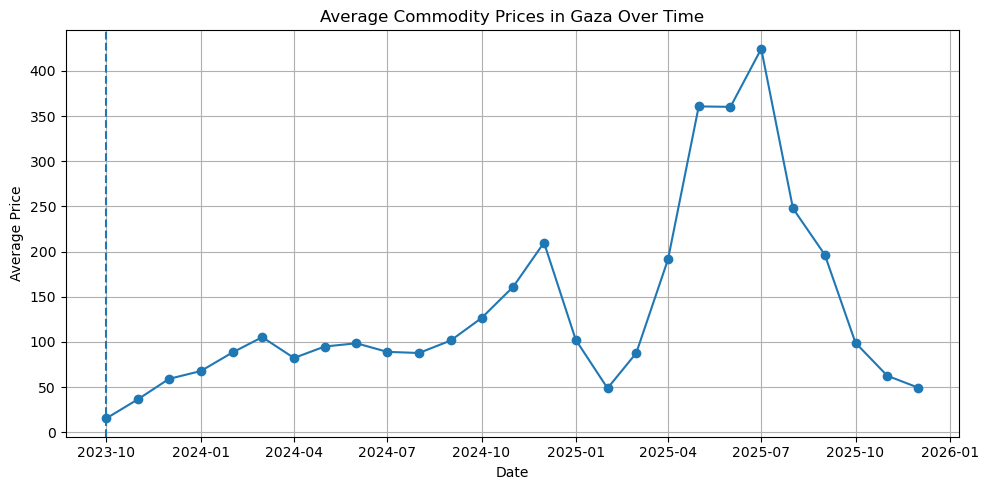

In [7]:
df = con.execute("""
    SELECT
        full_date,
        AVG(price) AS avg_price
    FROM main_mart.commodity_price_trends
    GROUP BY full_date
    ORDER BY full_date
""").df()

plt.figure(figsize=(10, 5))
plt.plot(df["full_date"], df["avg_price"], marker="o")
plt.axvline(pd.to_datetime("2023-10-01"), linestyle="--")
plt.title("Average Commodity Prices in Gaza Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

By visualising the average commodity prices over time, it can be seen that prices generally climbed when there were no active ceasefires. The drops in January 2025 can likely be attributed to the ceasefire at that time. Meanwhile the drop in August 2025 appears to be before the ceasefire which began in October. It is plausible that there was increased aid avaiable prior to the ceasefire. 

There was a slight reduction in prices around April 2024, meanwhile prices seemed to spike strongly either side of the January 2025 to March 2025 ceasefire. This change appears to be larger than what would typically be expected from short term volatility alone, suggesting that additional factors may have contributed - such as additional aid restrictions, weather/explosives effecting agriculture or destruction of infrastructure. Analysing aid distribution should help in understanding why these happened, and will be investigated in the next notebook.

### Individual commodity prices by month

In this section, individual commodities will be investigated and compared. 

In the following table, the top 10 commodites with the highest percentage change from the baseline price are listed along with the date that this happened.

In [10]:
con.execute("""
    WITH max_unique AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY commodity_name, unit_amount ORDER BY pct_change_from_baseline DESC) AS rn
    FROM main_mart.commodity_price_change_from_baseline
    )

    SELECT
        commodity_name,
        unit_amount,
        ROUND(price, 2) AS price,
        baseline_price,
        STRFTIME(full_date, '%B %Y') AS date,
        pct_change_from_baseline
    FROM max_unique
    WHERE rn = 1
    ORDER BY pct_change_from_baseline DESC
""").df().head(15)

,commodity_name,unit_amount,price,baseline_price,date,pct_change_from_baseline
0,pure white sugar,10 kg,3072.86,35.60,July 2025,8531.62
1,marlboro cigarettes,20 pack,1933.33,24.72,December 2024,7720.93
2,chili pepper,1 kg,291.25,3.75,September 2024,7666.67
3,dry onions,1 kg,240.36,3.63,June 2025,6521.40
4,l-m cigarettes,20 pack,1350.00,21.69,December 2024,6124.07
5,gas cylinder,12 kg,4200.00,71.25,September 2025,5794.74
6,gasoline,1 L,380.00,6.79,August 2025,5496.47
7,eggs,2 kg,600.00,13.33,October 2025,4401.13
8,cucumbers,1 kg,68.63,1.56,July 2025,4299.42
9,lemons,1 kg,90.00,2.56,June 2025,3415.63


One thing that can be seen from this table is that almost all the items on the list saw their highest ever prices between May 2025 and September 2025. The notable exceptions are the two types of cigarettes and eggplants which saw their highest ever prices in December 2024.

Sugar tops the list, which may be due to it's high calorie density which is extremely valuable when food is scarce.

Since the vast majority of the items saw their highest prices roughly around the same time, plotting a graph of each commodity's maximum percentage increase from the baseline price should help visualise how much the price of each commodity increased by as a percentage.  

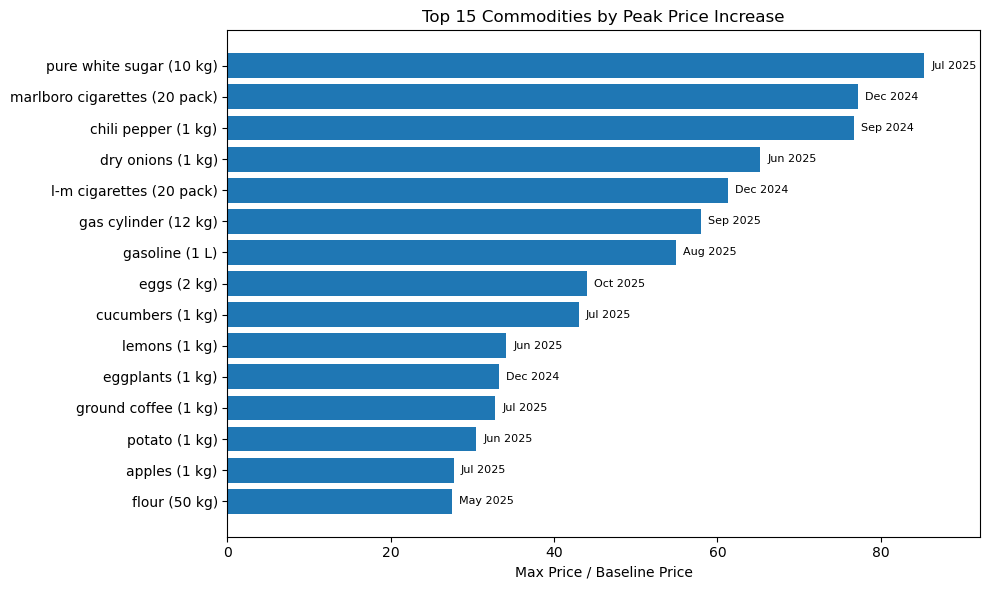

In [12]:
df = con.execute("""
    WITH ranked AS
    (
    SELECT
        commodity_name,
        unit_amount,
        commodity_category,
        baseline_price,
        price,
        pct_change_from_baseline / 100 AS price_divide_baseline,
        full_date,
        ROW_NUMBER() OVER (PARTITION BY commodity_name, unit_amount ORDER BY pct_change_from_baseline DESC) AS rn
    FROM main_mart.commodity_price_change_from_baseline
    )

    SELECT
        commodity_name,
        unit_amount,
        commodity_category,
        baseline_price,
        price AS max_price,
        price_divide_baseline AS max_price_divide_baseline,
        full_date AS max_price_date
    FROM ranked
    WHERE rn = 1
    ORDER BY price_divide_baseline DESC
    LIMIT 15
""").df()

plt.figure(figsize=(10, 6))
plt.barh(df["commodity_name"] + " (" + df["unit_amount"] + ")", df["max_price_divide_baseline"])
plt.gca().invert_yaxis()
plt.title("Top 15 Commodities by Peak Price Increase")
plt.xlabel("Max Price / Baseline Price")
plt.xlim(0, df["max_price_divide_baseline"].max() * 1.08)
plt.tight_layout()

offset = df["max_price_divide_baseline"].max() * 0.01
for i, value in enumerate(df["max_price_date"]):
    plt.text(df["max_price_divide_baseline"].iloc[i] + offset, i, value.strftime("%b %Y"), va="center", fontsize=8)

plt.show()

The most immediate observation is the significant variance in price increases across commodities. Even within only the top 15 largest increases, the magnitude differs substantially. At their peak - flour was 28 times more expensive than its baseline price, while sugar was a massive 85 times more expensive that its baseline price. For the vast majority of commodities, the peak price increases occured between May 2025 and October 2025, suggesting a period of heighted market stress. Exceptions were cigarettes, chili peppers and eggplants - all of which saw their peak in December 2024.

Staple ingredients, fruits and vegetables, fuel and cigarettes are all prominently represented. Key nutritional items are present as expected, however, cigarettes also appear among the largest price increases, despite not being a nutritional necessity. A plausable explanation for this could be that they are unlikely to be supplied through aid, whilst also being highly addictive, thus inflating the price.

A notable absentee is meat. Eggs are the only high protein commodity in appearing in the top 15, despite expectations that chicken or red meat would feature.

The following scatter plot contrasts each commodity's baseline price with their peak price, colour coded by commodity category which helps visualise whether particular categories exhibit notable trends.

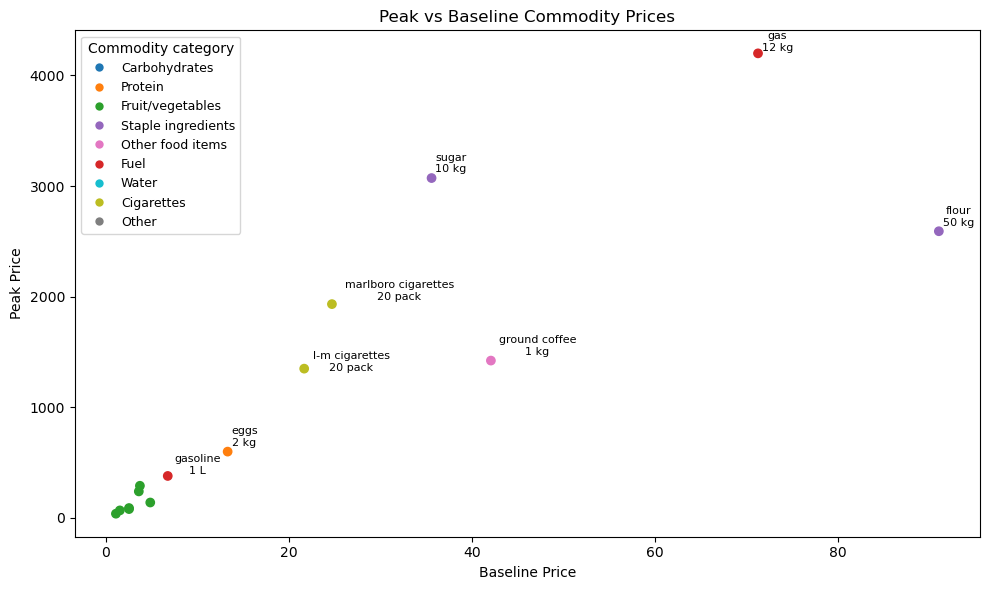

In [14]:
category_colours = {
    "Carbohydrates": "tab:blue",
    "Protein": "tab:orange",
    "Fruit/vegetables": "tab:green",
    "Staple ingredients": "tab:purple",
    "Other food items": "tab:pink",
    "Fuel": "tab:red",
    "Water": "tab:cyan",
    "Cigarettes": "tab:olive",
    "Other": "tab:gray"
}

colours = df["commodity_category"].map(category_colours)

plt.figure(figsize=(10, 6))
plt.scatter(df["baseline_price"], df["max_price"], c=colours)


df["scatter_labels"] = (
    df["commodity_name"]
    .str.replace("pure white ", "")
    .str.replace(" cylinder", "")
    .str.replace(" distributed using tankers", "")
    + "\n" + df["unit_amount"]
    .str.replace("liters", "L")
)

label_df = df[(df["baseline_price"] > 10) | (df["max_price"] > 300)]


texts = []
for index, row in label_df.iterrows():
    texts.append(
    plt.text(
        row["baseline_price"],
        row["max_price"],
        row["scatter_labels"],
        fontsize=8
    ))

adjust_text(
    texts,
    force_text=(0.1, 0.1),
    force_points=(0.1, 0.1),
    expand_text=(1.05, 1.1),
    expand_points=(1.05, 1.1)
)

legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        label=category,
        markerfacecolor=colour,
        markeredgewidth=0,
        markersize=6
    )
    for category, colour in category_colours.items()
]

plt.legend(
    handles=legend_elements,
    title="Commodity category",
    loc="best",
    fontsize=9
)

plt.xlabel("Baseline Price")
plt.ylabel("Peak Price")
plt.title("Peak vs Baseline Commodity Prices")
plt.tight_layout()
plt.show()




Fruits and vegetables are grouped in the bottom left corner of the scatter plot. This is due to low baseline prices and similar maximum price spikes, likely due to fruits and vegetables generally being interchangeable. If a particular fruit or vegetable becomes scarce and sees short term price inflation, it's presumed that people will buy other alternatives instead which would ease demand on that particular item. This kind of elastic demand ensures that items in the fruit and vegetables category remain grouped together on the graph.

In general, whilst it was expected that there would be a general trend between baseline price and peak price, the trend is a little tighter than initially thought. It was thought that certain products would be huge outliers if there was an extreme short term scarcity due to aid restrictions or difficulties in distribution.

That being said there are some products slightly away from the trendline, with gas, sugar and cigarettes sitting above and flour sitting below. Some possible reasons for these are listed below:
- Gas 12kg: multiple uses such as cooking and heating, whilst being difficult to transport.
- Sugar 10kg: very calorie dense
- Cigarettes 20 pack: not necessary for survival but addictive, unlikely to be included in aid
- Flour 50kg: important ingredient but lots of alternate carbohydrates are available


### Conclusion

This analysis shows that average commodity prices in Gaza generally increased, with noticable price relief during ceasefire windows. Prices also seemed to fall slightly prior to the official beginning of the ceasefires - most clearly before the 3rd October 2025 ceasefire. This supports the hypothesis that heighten hostilities and restricted access place upward pressure on commodity prices, while ceasefires provide a temporary easing.

The scale of prices changes, many multiples from the baseline prices, suggests that long term structural factors were also at play. The prices spiked sharply at the end of 2024 and even more so in the middle of 2025, indicating disruptions to supply chains, infrastructure damage, and constraints on aid.

At the commodity level, fruits and vegetables were grouped due to their similarly low baseline prices and similar increases in prices - possibly due to their interchangablity.

In all, the findings suggest that conflict intensity and commodity specific characteristics had significant effect on price dynamics, motivating further analysis of prices along with aid distribution data in the next stage of this project.